# Deux labo : résultat contradictoire ?

In [3]:
#importation package
import pandas as pd
import duckdb

#config affichage
pd.set_option("display.max_columns", None)  # Affiche toutes les colonnes sans limitation
pd.set_option("display.max_colwidth", None)  # Affiche la largeur complète des colonnes sans couper le texte
pd.set_option("display.expand_frame_repr", False)  # Empêche le repliement des colonnes lors de l'affichage du DataFrame

# Connexion
from pipelines.tasks.config.common import DUCKDB_FILE
con = duckdb.connect(database=DUCKDB_FILE, read_only=True)


## Identifier : plusieurs analyses pour un prélévement  ##

un prélévement fait l'objet d'un ou plusieurs analyses pour le même paramètre  
eg :  
- referenceprel 00100143885, deux analyses pour le paramètre ASP  
- referenceprel 97300062104, deux analyses pour le paramètre PH  



In [4]:
# prélévement avec plusieurs analyse d'un même paramètre
query_plusieurs_analyses = """ 
SELECT referenceprel, cdparametresiseeaux, COUNT(cdparametresiseeaux) AS nbanalyse
FROM edc_resultats
GROUP BY referenceprel, cdparametresiseeaux
HAVING nbanalyse >1
ORDER BY nbanalyse DESC, referenceprel, cdparametresiseeaux
 """
plusieurs_analyses = con.sql(query_plusieurs_analyses).df()
plusieurs_analyses

,referenceprel,cdparametresiseeaux,nbanalyse
0,00100143885,ASP,2
1,00100143885,ODQ,2
2,00100143899,ASP,2
3,00100143899,ODQ,2
4,00100143936,ASP,2
...,...,...,...
8177,97300062104,PH,2
8178,97300062105,PH,2
8179,97300062106,PH,2
8180,97300062110,PH,2


## Explo global : plusieurs analyses - résultats contradictoires ##

Un prélévement peut faire l'objet de plusieurs analyses, sur terrain et/ou en laboratoire.  
Les résultats peuvent être contradictoire pour le même paramètre analysé

##### Un paramètre - plusieurs analyses #####

In [5]:
# edc_resultat avec plusieurs analyse d'un paramètre
query_resultat_plusieurs_analyses = """ 
WITH
plusieurs_resultats AS (
SELECT referenceprel, cdparametresiseeaux, COUNT(cdparametresiseeaux) AS nbanalyse
FROM edc_resultats
GROUP BY referenceprel, cdparametresiseeaux
HAVING nbanalyse >1
ORDER BY nbanalyse DESC, referenceprel, cdparametresiseeaux)
,
resultat_diff AS (
SELECT *,
LAG(valtraduite ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux ) AS valtraduite_1, 
valtraduite AS valtraduite_0, 
LEAD(valtraduite ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux) AS valtraduite_2,
FROM edc_resultats
WHERE referenceprel IN (SELECT DISTINCT referenceprel
                        FROM plusieurs_resultats)
ORDER BY referenceprel,cdparametresiseeaux)

SELECT *
FROM resultat_diff
WHERE  valtraduite_1 IS NOT NULL OR valtraduite_2 IS NOT NULL
ORDER BY referenceprel, cdparametresiseeaux

 """
resultat_plusieurs_analyses = con.sql(query_resultat_plusieurs_analyses).df()
resultat_plusieurs_analyses

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,de_partition,de_ingestion_date,de_dataset_datetime,valtraduite_1,valtraduite_0,valtraduite_2
0,001,00100143885,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,SANS OBJET,X,None,None,0.00,None,00100152955,2025,2025-03-20,20250303-093730,1.0,0.00,NaN
1,001,00100143885,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect anormal,SANS OBJET,X,None,None,1.00,None,00100152954,2025,2025-03-20,20250303-093730,NaN,1.00,0.00
2,001,00100143885,ODQ,5901,ODEUR (QUALITATIF),Odeur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.00,None,00100152954,2025,2025-03-20,20250303-093730,0.0,0.00,NaN
3,001,00100143885,ODQ,5901,ODEUR (QUALITATIF),Odeur (qualitatif),None,O,L,Aucun changement anormal,SANS OBJET,X,None,None,0.00,None,00100152955,2025,2025-03-20,20250303-093730,NaN,0.00,0.00
4,001,00100143899,ASP,6489,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,SANS OBJET,X,None,None,0.00,None,00100152969,2025,2025-03-20,20250303-093730,0.0,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16248,973,97300062106,PH,1302,PH,pH,None,N,L,"7,7",unité pH,264,None,">=6,5 et <=9 unité pH",7.70,None,97300064408,2025,2025-03-20,20250303-093730,NaN,7.70,7.59
16249,973,97300062106,PH,1302,PH,pH,None,N,T,"7,59",unité pH,264,None,">=6,5 et <=9 unité pH",7.59,None,None,2025,2025-03-20,20250303-093730,7.7,7.59,NaN
16250,973,97300062110,PH,1302,PH,pH,None,N,T,"7,37",unité pH,264,None,">=6,5 et <=9 unité pH",7.37,None,None,2025,2025-03-20,20250303-093730,6.8,7.37,NaN
16251,973,97300062110,PH,1302,PH,pH,None,N,L,"6,8",unité pH,264,None,">=6,5 et <=9 unité pH",6.80,None,97300064414,2025,2025-03-20,20250303-093730,NaN,6.80,7.37


#### Plusieurs analyses - résultats contradictoires ####

3 cas :  
- le prélèvement n'a pas été analysé mais affiche une valtraduite
- le prélèvement a été analysé sur terrain, ensuite une autre analyse en laboratoire (résultats différents)
- le prélèvement a été analysé plusieurs fois en laboratoires

eg types de résultats contradictoires : 
Pour les qualitparam qualitatif (O)

- referenceprel 00100143885 -  rqana : Aspect anormal # Aspect normal  - valtraduite : 1.0 # 0.0 - insituana   L # L - ASP
- referenceprel 08800187383 -  rqana : Aucun changement anormal # Changement anormal - valtraduite : 0.0 # 1.0 - insituana  T # L - ODQ
- referenceprel 01000107839 -  rqana : Aucun changement anormal # Non mesuré - valtraduite : 0.0 # 2.0 - insituana T # L - ODQ

Pour les qualitparam quantitatif (N)
- referenceprel 97300062104 - rqana : <6.5 # 6.1 - valtraduite : 0.0 # 6.1 - insituana T # L - PH
- referenceprel 03800341940 - rqana : 1091 # 973 - valtraduite : 1091 # 973 - insituana T # L - CDT25





In [6]:
#Explo global resultats différent
query_explo_global_resultat_diff = """ 

SELECT referenceprel, cdparametresiseeaux, libmajparametre, insituana, cdunitereference, limitequal, refqual, rqana, qualitparam, valtraduite_1, valtraduite_0, valtraduite_2, 
FROM resultat_plusieurs_analyses
WHERE (valtraduite_1 != valtraduite_0 OR valtraduite_0 != valtraduite_2)
ORDER BY referenceprel, cdparametresiseeaux

"""
explo_global_resultat_diff = con.sql(query_explo_global_resultat_diff).df()
explo_global_resultat_diff

,referenceprel,cdparametresiseeaux,libmajparametre,insituana,cdunitereference,limitequal,refqual,rqana,qualitparam,valtraduite_1,valtraduite_0,valtraduite_2
0,00100143885,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect normal,O,1.0,0.00,NaN
1,00100143885,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect anormal,O,NaN,1.00,0.00
2,00100144017,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect normal,O,1.0,0.00,NaN
3,00100144017,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect anormal,O,NaN,1.00,0.00
4,00500134383,PH,PH,L,264,None,">=6,5 et <=9 unité pH","7,87",N,NaN,7.87,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...
13917,97300062105,PH,PH,T,264,None,">=6,5 et <=9 unité pH","7,06",N,6.8,7.06,NaN
13918,97300062106,PH,PH,T,264,None,">=6,5 et <=9 unité pH","7,59",N,7.7,7.59,NaN
13919,97300062106,PH,PH,L,264,None,">=6,5 et <=9 unité pH","7,7",N,NaN,7.70,7.59
13920,97300062110,PH,PH,T,264,None,">=6,5 et <=9 unité pH","7,37",N,6.8,7.37,NaN


In [7]:
#Explo global resultats différent - types prélévements (referenceprel)
query_type_referenceprel = """ 

SELECT *
FROM explo_global_resultat_diff
WHERE referenceprel IN ('00100143885','08800187383','01000107839','97300062104','03800341940' )
ORDER BY   qualitparam DESC, referenceprel, cdparametresiseeaux, insituana DESC 

"""
type_referenceprel = con.sql(query_type_referenceprel).df()
type_referenceprel

,referenceprel,cdparametresiseeaux,libmajparametre,insituana,cdunitereference,limitequal,refqual,rqana,qualitparam,valtraduite_1,valtraduite_0,valtraduite_2
0,00100143885,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect normal,O,1.0,0.0,NaN
1,00100143885,ASP,ASPECT (QUALITATIF),L,X,None,None,Aspect anormal,O,NaN,1.0,0.0
2,01000107839,ODQ,ODEUR (QUALITATIF),T,X,None,None,Aucun changement anormal,O,2.0,0.0,NaN
3,01000107839,ODQ,ODEUR (QUALITATIF),L,X,None,None,Non mesuré,O,NaN,2.0,0.0
4,08800187383,ODQ,ODEUR (QUALITATIF),T,X,None,None,Aucun changement anormal,O,1.0,0.0,NaN
5,08800187383,ODQ,ODEUR (QUALITATIF),L,X,None,None,Changement anormal,O,NaN,1.0,0.0
6,01000107839,PH,PH,T,264,None,">=6,5 et <=9 unité pH","7,6",N,7.9,7.6,NaN
7,01000107839,PH,PH,L,264,None,">=6,5 et <=9 unité pH","7,9",N,NaN,7.9,7.6
8,03800341940,CDT25,CONDUCTIVITÉ À 25°C,T,147,None,>=200 et <=1100 µS/cm,1091,N,973.0,1091.0,NaN
9,03800341940,CDT25,CONDUCTIVITÉ À 25°C,L,147,None,>=200 et <=1100 µS/cm,973,N,NaN,973.0,1091.0


#### Explo insituana ( T - L )

Les différences de résultats concernent les analyses faites selon :   
-  Terrain vs  Labo
-  Labo vs  Labo

104 prélévements, analysés seulement une fois sur Terrain    
7 prélévements, analysés seulement une fois en laboratoire  
90 prélévements, analysés en Laboratoire et une deuxième fois en laboratoire dont 12 présentent des différences de résultats - 13 %
16052 prélévements, analysés une première fois sur Terrain ensuite en Laboratoire dont 13910 présentent des différences de résultats - 87 %


In [23]:
#Explo global type d'analyse (Labo / terrain)

query_type_analyse = """ 

WITH type_insituana AS(
SELECT referenceprel, cdparametresiseeaux, valtraduite_1, valtraduite_0, valtraduite_2, 
LAG(insituana ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux, insituana DESC ) AS insituana_1, 
insituana AS insituana_0, 
LEAD(insituana ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux, insituana DESC ) AS insituana_2,
FROM resultat_plusieurs_analyses
ORDER BY referenceprel, cdparametresiseeaux)
,
combi_insituana AS (
SELECT
CASE 
WHEN insituana_1 IS NULL AND insituana_2 IS NOT NULL THEN insituana_0||insituana_2
WHEN insituana_1 IS NOT NULL AND insituana_2 IS NULL THEN insituana_1||insituana_0
ELSE insituana_0
END AS type_insituana
FROM type_insituana)

SELECT type_insituana, COUNT(*) AS nb_plusieurs_resultats
FROM combi_insituana
GROUP BY type_insituana

"""
type_analyse = con.sql(query_type_analyse).to_df()
type_analyse

,type_insituana,nb_plusieurs_resultats
0,TL,16052
1,T,104
2,LL,90
3,L,7


In [24]:
query_freq_insituana_valdiff = """ 
WITH type_insituana AS(
SELECT referenceprel, cdparametresiseeaux, valtraduite_1, valtraduite_0, valtraduite_2, 
LAG(insituana ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux, insituana DESC ) AS insituana_1, 
insituana AS insituana_0, 
LEAD(insituana ) OVER(PARTITION BY referenceprel, cdparametresiseeaux ORDER BY referenceprel,cdparametresiseeaux, insituana DESC ) AS insituana_2,
FROM explo_global_resultat_diff
ORDER BY referenceprel, cdparametresiseeaux)
,
combi_insituana AS (
SELECT
CASE 
WHEN insituana_1 IS NULL AND insituana_2 IS NOT NULL THEN insituana_0||insituana_2
WHEN insituana_1 IS NOT NULL AND insituana_2 IS NULL THEN insituana_1||insituana_0
ELSE insituana_0
END AS type_insituana
FROM type_insituana)

SELECT type_insituana, COUNT(*) AS nb_resultat_diff
FROM combi_insituana
GROUP BY type_insituana

 """
freq_insituana_valdiff = con.sql(query_freq_insituana_valdiff).to_df()
freq_insituana_valdiff



,type_insituana,nb_resultat_diff
0,LL,12
1,TL,13910


In [43]:
df_plot = type_analyse.merge(freq_insituana_valdiff, how='left')
df_plot[['nb_plusieurs_resultats','nb_resultat_diff']] = df_plot[['nb_plusieurs_resultats','nb_resultat_diff']].fillna(0).astype(int)
df_plot


,type_insituana,nb_plusieurs_resultats,nb_resultat_diff
0,TL,16052,13910
1,T,104,0
2,LL,90,12
3,L,7,0


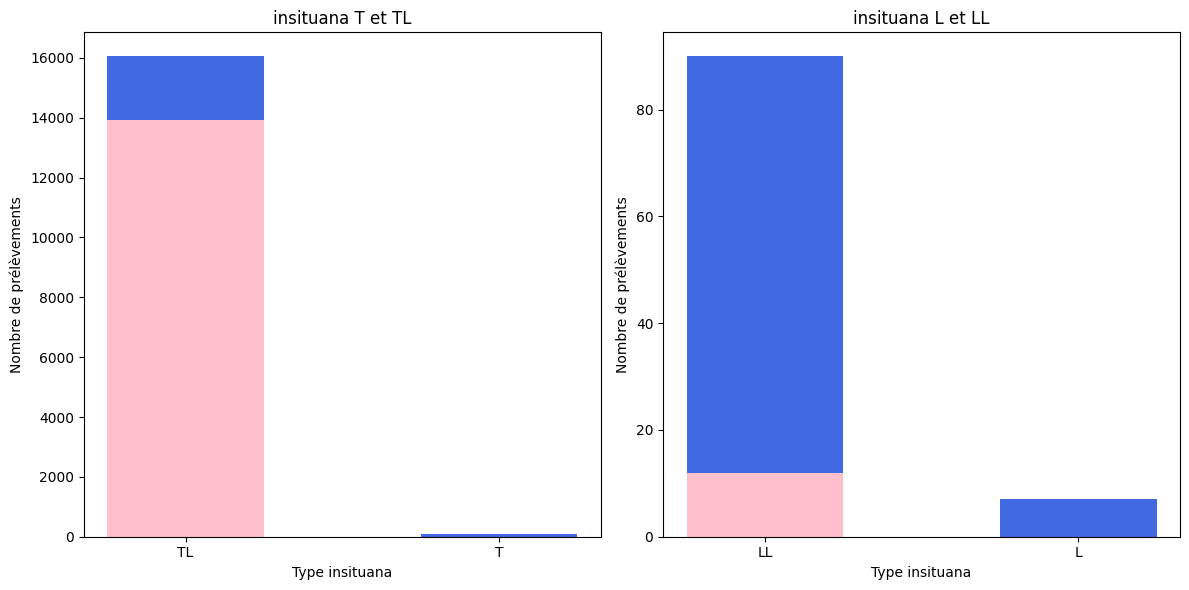

In [ ]:
import matplotlib.pyplot as plt

# Création des deux graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#  'T' et 'TL'
df_plot_t = df_plot[df_plot['type_insituana'].isin(['T','TL'])]
x_t = df_plot_t['type_insituana']
y_t = df_plot_t['nb_plusieurs_resultats']
z_t = df_plot_t['nb_resultat_diff']
ax[0].bar(x_t, y_t, color='royalblue', width=0.5)
ax[0].bar(x_t, z_t, color='pink', width=0.5)
ax[0].set_title('insituana T et TL')
ax[0].set_xlabel('Type insituana')
ax[0].set_ylabel('Nombre de prélèvements')

# 'L' et 'LL'
df_plot_l = df_plot[df_plot['type_insituana'].isin(['L','LL'])]
x_l = df_plot_l['type_insituana']
y_l = df_plot_l['nb_plusieurs_resultats']
z_l = df_plot_l['nb_resultat_diff']
ax[1].bar(x_l, y_l, color='royalblue', width=0.5)
ax[1].bar(x_l, z_l, color='pink', width=0.5)
ax[1].set_title('insituana L et LL')
ax[1].set_xlabel('Type insituana')
ax[1].set_ylabel('Nombre de prélèvements')

# Ajuster l'espacement et afficher
plt.tight_layout()
plt.show()

### Les paramètres concerné par plusieurs analyses

Les catégories de paramètres concernées sont "paramètre organoleptique", "pesticides" , "nitrite"

In [19]:
query_parametre = """ 
WITH 
paramètre_plusieurs_resultats AS (
SELECT DISTINCT cdparametresiseeaux
FROM plusieurs_analyses )
,
paramètre_global AS (
SELECT DISTINCT cdparametresiseeaux
FROM edc_resultats
)
,
resultat_diff AS (
SELECT  cdparametresiseeaux, COUNT(*) AS freq_diff
FROM explo_global_resultat_diff
GROUP BY cdparametresiseeaux )

SELECT rd.cdparametresiseeaux , mc.categorie, rd.freq_diff
FROM resultat_diff AS rd
LEFT JOIN mapping_categories AS mc
ON rd.cdparametresiseeaux = mc.cdparametresiseeaux
  """

parametre = con.sql(query_parametre).df()
parametre


,cdparametresiseeaux,categorie,freq_diff
0,TEMP_PH,paramètre organoleptique,860
1,SAVQ,paramètre organoleptique,2
2,ODQ,paramètre organoleptique,714
3,NO3,nitrite,2
4,ASP,paramètre organoleptique,4
5,NO3,nitrite,2
6,CDT25,paramètre organoleptique,1766
7,TURBNFU,paramètre organoleptique,16
8,PESTOT,pesticides,6
9,PH,paramètre organoleptique,10552


## Conclusion ##

Un paramètre issu d'un même prélévement peut faire l'objet de plusieurs analyses dont une première analyse sur terrain et plusieurs analyses en laboratoires.  

Les analyses sur terrain (insituana = T ) ne sont pas référencé - pas de référence d'analyse 'referenceanl'  

Les résultats contradictoires sont présents sur des configuration :  
    - analyse 1 sur Terrain - analyse 2 en Laboratoire ( insituana T - L )  
    - analyse 1 en Laboratoire - analyse 2 en Laboratoire (ou plus) ( insituana L - L )  
 

Les informations de la table edc_resultats ne permet pas d'identifier les raisons exact qui amène à ces contradictions ( à creuser ?? ) :  
les lignes concernées présente des valeurs identiques pour chaque champ à part :  referenceanl - rqana - valtraduite  



